1. Membaca dan Memproses Dataset

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Membaca dataset nutrisi
print("Membaca dataset nutrisi...")
df_nutrition_tkpi = pd.read_csv('raw_nutrition_tkpi_scraped.csv')
df_nutrition_supplement = pd.read_csv('raw_nutrition_supplement.csv')

# Menggabungkan dataset nutrisi
df_nutrition = pd.concat([df_nutrition_tkpi, df_nutrition_supplement], ignore_index=True)

# Membersihkan data nutrisi
df_nutrition['ingredient'] = df_nutrition['ingredient'].str.strip().str.lower()
df_nutrition = df_nutrition.drop_duplicates(subset=['ingredient'])
df_nutrition = df_nutrition.fillna(0)

print(f"Total bahan makanan dalam dataset nutrisi: {len(df_nutrition)}")
print(df_nutrition.head())

# Membaca dataset resep
print("\nMembaca dataset resep...")
dataset_files = {
    'udang': 'raw_dataset-udang.csv',
    'tempe': 'raw_dataset-tempe.csv',
    'telur': 'raw_dataset-telur.csv',
    'tahu': 'raw_dataset-tahu.csv',
    'sapi': 'raw_dataset-sapi.csv',
    'kambing': 'raw_dataset-kambing.csv',
    'ikan': 'raw_dataset-ikan.csv',
    'ayam': 'raw_dataset-ayam.csv'
}

# Membaca semua dataset resep
all_recipes = []
for category, filename in dataset_files.items():
    try:
        df_temp = pd.read_csv(filename)
        df_temp['category'] = category
        all_recipes.append(df_temp)
        print(f"Dataset {category}: {len(df_temp)} resep")
    except FileNotFoundError:
        print(f"File {filename} tidak ditemukan")

# Menggabungkan semua resep
df_recipes = pd.concat(all_recipes, ignore_index=True)
print(f"\nTotal resep: {len(df_recipes)}")

# Membaca combined dataset
df_combined = pd.read_csv('raw_combined_dataset.csv')
print(f"Combined dataset: {len(df_combined)} resep")

Membaca dataset nutrisi...
Total bahan makanan dalam dataset nutrisi: 1232
             ingredient  calories  protein  fat  carbohydrates  fiber  calcium
0                  nasi       180      3.0  0.3           39.8    0.2     25.0
1              nasi tim       120      2.4  0.4           26.0    0.5      3.0
2           tapai beras        99      1.7  0.3           22.4    0.0      4.0
3  tepung beras. mentah       353      7.0  0.5           80.0    2.4      5.0
4      nasi beras merah       149      2.8  0.4           32.5    0.3      6.0

Membaca dataset resep...
Dataset udang: 1994 resep
Dataset tempe: 1986 resep
Dataset telur: 1974 resep
Dataset tahu: 1985 resep
Dataset sapi: 1958 resep
Dataset kambing: 1896 resep
Dataset ikan: 1932 resep
Dataset ayam: 1916 resep

Total resep: 15641
Combined dataset: 80 resep


2. Preprocessing Data Resep dan Ekstraksi Ingredients

In [4]:
import re

def extract_ingredients(ingredients_str):
    """Ekstrak bahan-bahan dari string ingredients"""
    if pd.isna(ingredients_str):
        return []
    
    # Split berdasarkan '--'
    ingredients_list = ingredients_str.split('--')
    
    # Bersihkan setiap ingredient
    cleaned_ingredients = []
    for ingredient in ingredients_list:
        # Hapus angka di awal dan unit pengukuran
        ingredient = re.sub(r'^\d+[\s\w]*', '', ingredient)
        ingredient = re.sub(r'\(.*?\)', '', ingredient)
        ingredient = ingredient.strip().lower()
        
        if ingredient and len(ingredient) > 2:
            cleaned_ingredients.append(ingredient)
    
    return cleaned_ingredients

# Ekstrak ingredients dari semua resep
print("Mengekstrak ingredients dari resep...")
df_recipes['ingredients_list'] = df_recipes['Ingredients'].apply(extract_ingredients)
df_combined['ingredients_list'] = df_combined['Ingredients'].apply(extract_ingredients)

# Gabungkan semua resep
all_recipes_df = pd.concat([
    df_recipes[['Title', 'ingredients_list', 'category']],
    df_combined[['Title', 'ingredients_list']].assign(category='mixed')
], ignore_index=True)

print(f"Total resep setelah digabung: {len(all_recipes_df)}")

Mengekstrak ingredients dari resep...
Total resep setelah digabung: 15721


3. Membuat Dataset Profil Pengguna

In [5]:
# Generate synthetic user data
np.random.seed(42)

def calculate_bmr(weight, height, age, gender):
    """Menghitung BMR menggunakan rumus Mifflin-St Jeor"""
    if gender == 'Laki-laki':
        return 10 * weight + 6.25 * height - 5 * age + 5
    else:
        return 10 * weight + 6.25 * height - 5 * age - 161

def calculate_tdee(bmr, activity_level):
    """Menghitung TDEE berdasarkan tingkat aktivitas"""
    activity_multipliers = {
        'Sangat Rendah': 1.2,
        'Rendah': 1.375,
        'Sedang': 1.55,
        'Tinggi': 1.725,
        'Sangat Tinggi': 1.9
    }
    return bmr * activity_multipliers[activity_level]

# Generate user data
n_users = 3000
user_data = []

for i in range(n_users):
    age = np.random.randint(18, 65)
    gender = np.random.choice(['Laki-laki', 'Perempuan'])
    
    if gender == 'Laki-laki':
        weight = np.random.normal(70, 15)
        height = np.random.normal(170, 8)
    else:
        weight = np.random.normal(60, 12)
        height = np.random.normal(160, 7)
    
    weight = max(40, min(120, weight))
    height = max(140, min(200, height))
    
    activity_level = np.random.choice([
        'Sangat Rendah', 'Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi'
    ], p=[0.1, 0.3, 0.4, 0.15, 0.05])
    
    goal = np.random.choice([
        'Menurunkan berat badan', 'Mempertahankan berat badan', 'Menaikkan berat badan'
    ], p=[0.4, 0.4, 0.2])
    
    bmr = calculate_bmr(weight, height, age, gender)
    tdee = calculate_tdee(bmr, activity_level)
    
    # Hitung target kalori berdasarkan tujuan
    if goal == 'Menurunkan berat badan':
        target_calories = max(1200, tdee - 500)
        calorie_category = 'Defisit'
    elif goal == 'Menaikkan berat badan':
        target_calories = tdee + 500
        calorie_category = 'Surplus'
    else:
        target_calories = tdee
        calorie_category = 'Maintenance'
    
    # Tentukan kategori kebutuhan nutrisi
    if target_calories < 1500:
        nutrient_category = 'Rendah'
    elif target_calories < 2000:
        nutrient_category = 'Sedang'
    elif target_calories < 2500:
        nutrient_category = 'Tinggi'
    else:
        nutrient_category = 'Sangat Tinggi'
    
    user_data.append({
        'user_id': i+1,
        'age': int(age),
        'gender': gender,
        'weight': round(weight, 1),
        'height': round(height, 1),
        'activity_level': activity_level,
        'goal': goal,
        'bmr': round(bmr, 1),
        'tdee': round(tdee, 1),
        'target_calories': round(target_calories, 1),
        'calorie_category': calorie_category,
        'nutrient_category': nutrient_category
    })

df_users = pd.DataFrame(user_data)
print("Dataset pengguna berhasil dibuat!")
print(f"Jumlah data pengguna: {len(df_users)}")
print(df_users.head())

Dataset pengguna berhasil dibuat!
Jumlah data pengguna: 3000
   user_id  age     gender  weight  height activity_level  \
0        1   56  Perempuan    46.7   162.2         Rendah   
1        2   41  Laki-laki    93.7   176.1  Sangat Rendah   
2        3   61  Perempuan    53.0   156.3         Rendah   
3        4   39  Laki-laki    44.1   165.5         Sedang   
4        5   45  Perempuan    51.6   145.0         Sedang   

                     goal     bmr    tdee  target_calories calorie_category  \
0  Menurunkan berat badan  1039.5  1429.3           1200.0          Defisit   
1   Menaikkan berat badan  1837.8  2205.3           2705.3          Surplus   
2  Menurunkan berat badan  1041.3  1431.8           1200.0          Defisit   
3  Menurunkan berat badan  1285.6  1992.8           1492.8          Defisit   
4  Menurunkan berat badan  1036.0  1605.8           1200.0          Defisit   

  nutrient_category  
0            Rendah  
1     Sangat Tinggi  
2            Rendah  
3        

4. Model Machine Learning untuk Prediksi Kebutuhan Kalori

In [6]:
# Preprocessing untuk model
le_gender = LabelEncoder()
le_activity = LabelEncoder()
le_goal = LabelEncoder()
le_calorie_cat = LabelEncoder()
le_nutrient_cat = LabelEncoder()

# Encode categorical variables
df_users_encoded = df_users.copy()
df_users_encoded['gender_encoded'] = le_gender.fit_transform(df_users['gender'])
df_users_encoded['activity_encoded'] = le_activity.fit_transform(df_users['activity_level'])
df_users_encoded['goal_encoded'] = le_goal.fit_transform(df_users['goal'])
df_users_encoded['calorie_category_encoded'] = le_calorie_cat.fit_transform(df_users['calorie_category'])
df_users_encoded['nutrient_category_encoded'] = le_nutrient_cat.fit_transform(df_users['nutrient_category'])

# Features untuk prediksi
features = ['age', 'gender_encoded', 'weight', 'height', 'activity_encoded', 'goal_encoded']
X = df_users_encoded[features]
y_calories = df_users_encoded['target_calories']
y_nutrient_cat = df_users_encoded['nutrient_category_encoded']

# Split data
X_train, X_test, y_cal_train, y_cal_test, y_cat_train, y_cat_test = train_test_split(
    X, y_calories, y_nutrient_cat, test_size=0.2, random_state=42
)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Prediksi Target Kalori (Regression)
print("Training model prediksi kalori...")
calorie_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
calorie_model.fit(X_train_scaled, y_cal_train)

# Evaluasi model kalori
y_cal_pred = calorie_model.predict(X_test_scaled)
mse = mean_squared_error(y_cal_test, y_cal_pred)
rmse = np.sqrt(mse)
r2_score = calorie_model.score(X_test_scaled, y_cal_test)

print(f"Model Prediksi Kalori - RMSE: {rmse:.2f}")
print(f"Model Prediksi Kalori - R2 Score: {r2_score:.3f}")

# Model 2: Klasifikasi Kategori Nutrisi
print("\nTraining model klasifikasi kategori nutrisi...")
category_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
category_model.fit(X_train_scaled, y_cat_train)

# Evaluasi model kategori
y_cat_pred = category_model.predict(X_test_scaled)
accuracy = accuracy_score(y_cat_test, y_cat_pred)

print(f"Model Klasifikasi Kategori - Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_cat_test, y_cat_pred, 
                          target_names=le_nutrient_cat.classes_))

Training model prediksi kalori...
Model Prediksi Kalori - RMSE: 81.90
Model Prediksi Kalori - R2 Score: 0.978

Training model klasifikasi kategori nutrisi...
Model Klasifikasi Kategori - Accuracy: 0.893

Classification Report:
               precision    recall  f1-score   support

       Rendah       0.97      0.90      0.93       118
Sangat Tinggi       0.91      0.92      0.92       115
       Sedang       0.85      0.91      0.88       177
       Tinggi       0.88      0.86      0.87       190

     accuracy                           0.89       600
    macro avg       0.90      0.90      0.90       600
 weighted avg       0.90      0.89      0.89       600



5. Sistem Rekomendasi Makanan Berbasis Nutrisi

In [7]:
class NutrilanceRecommendationSystem:
    def __init__(self, nutrition_df, recipes_df, calorie_model, category_model, 
                 scaler, encoders):
        self.nutrition_df = nutrition_df
        self.recipes_df = recipes_df
        self.calorie_model = calorie_model
        self.category_model = category_model
        self.scaler = scaler
        self.encoders = encoders
        
    def predict_calorie_needs(self, age, gender, weight, height, activity_level, goal):
        """Prediksi kebutuhan kalori pengguna"""
        # Encode input
        gender_encoded = self.encoders['gender'].transform([gender])[0]
        activity_encoded = self.encoders['activity'].transform([activity_level])[0]
        goal_encoded = self.encoders['goal'].transform([goal])[0]
        
        # Prepare features
        features = np.array([[age, gender_encoded, weight, height, 
                            activity_encoded, goal_encoded]])
        features_scaled = self.scaler.transform(features)
        
        # Predict
        target_calories = self.calorie_model.predict(features_scaled)[0]
        nutrient_category_encoded = self.category_model.predict(features_scaled)[0]
        nutrient_category = self.encoders['nutrient_category'].inverse_transform(
            [nutrient_category_encoded])[0]
        
        return target_calories, nutrient_category
    
    def calculate_nutrition_score(self, ingredient_row, target_calories, meal_type):
        """Hitung skor nutrisi untuk setiap bahan makanan"""
        # Distribusi kalori per jenis makanan
        meal_calorie_distribution = {
            'sarapan': 0.25,
            'makan_siang': 0.35,
            'makan_malam': 0.30,
            'snack': 0.10
        }
        
        target_meal_calories = target_calories * meal_calorie_distribution.get(meal_type, 0.25)
        
        # Hitung skor berdasarkan berbagai faktor
        calorie_diff = abs(ingredient_row['calories'] - target_meal_calories)
        calorie_score = 1 / (1 + calorie_diff / 100)  # Semakin dekat dengan target, semakin tinggi
        
        # Skor protein (protein tinggi lebih baik)
        protein_score = min(ingredient_row['protein'] / 30, 1)  # Normalize to 0-1
        
        # Skor serat (serat tinggi lebih baik)
        fiber_score = min(ingredient_row['fiber'] / 10, 1)  # Normalize to 0-1
        
        # Skor lemak (lemak sedang lebih baik)
        fat_score = 1 - abs(ingredient_row['fat'] - 15) / 50  # Optimal around 15g
        fat_score = max(0, fat_score)
        
        # Composite score
        total_score = (
            calorie_score * 0.4 +
            protein_score * 0.25 +
            fiber_score * 0.2 +
            fat_score * 0.15
        )
        
        return total_score
    
    def recommend_foods(self, target_calories, meal_type='all', n_recommendations=10):
        """Rekomendasi makanan berdasarkan target kalori"""
        # Copy dataframe
        recommendations_df = self.nutrition_df.copy()
        
        # Hitung skor untuk setiap makanan
        recommendations_df['nutrition_score'] = recommendations_df.apply(
            lambda row: self.calculate_nutrition_score(row, target_calories, meal_type),
            axis=1
        )
        
        # Sort berdasarkan skor
        recommendations_df = recommendations_df.sort_values('nutrition_score', ascending=False)
        
        # Ambil top N recommendations
        top_recommendations = recommendations_df.head(n_recommendations)
        
        return top_recommendations[['ingredient', 'calories', 'protein', 'fat', 
                                   'carbohydrates', 'fiber', 'calcium', 'nutrition_score']]
    
    def recommend_recipes(self, target_calories, preferred_category=None, n_recommendations=5):
        """Rekomendasi resep berdasarkan kategori dan kalori"""
        recipes = self.recipes_df.copy()
        
        # Filter berdasarkan kategori jika ada
        if preferred_category:
            recipes = recipes[recipes['category'] == preferred_category]
        
        # Random sampling untuk demo (dalam implementasi nyata, 
        # bisa menggunakan algoritma yang lebih sophisticated)
        if len(recipes) > n_recommendations:
            recommended_recipes = recipes.sample(n=n_recommendations)
        else:
            recommended_recipes = recipes
        
        return recommended_recipes[['Title', 'category']].reset_index(drop=True)
    
    def create_daily_meal_plan(self, target_calories, days=1):
        """Membuat rencana makan harian"""
        meal_plans = []
        
        for day in range(1, days + 1):
            daily_plan = {
                'day': day,
                'meals': {
                    'sarapan': {
                        'foods': self.recommend_foods(target_calories, 'sarapan', 3),
                        'recipes': self.recommend_recipes(target_calories, 'telur', 2)
                    },
                    'makan_siang': {
                        'foods': self.recommend_foods(target_calories, 'makan_siang', 4),
                        'recipes': self.recommend_recipes(target_calories, 'ayam', 2)
                    },
                    'makan_malam': {
                        'foods': self.recommend_foods(target_calories, 'makan_malam', 4),
                        'recipes': self.recommend_recipes(target_calories, 'ikan', 2)
                    },
                    'snack': {
                        'foods': self.recommend_foods(target_calories, 'snack', 2),
                        'recipes': self.recommend_recipes(target_calories, 'tempe', 1)
                    }
                }
            }
            meal_plans.append(daily_plan)
        
        return meal_plans

# Inisialisasi sistem rekomendasi
encoders = {
    'gender': le_gender,
    'activity': le_activity,
    'goal': le_goal,
    'calorie_category': le_calorie_cat,
    'nutrient_category': le_nutrient_cat
}

recommendation_system = NutrilanceRecommendationSystem(
    df_nutrition, all_recipes_df, calorie_model, category_model, scaler, encoders
)

print("Sistem rekomendasi NUTRILANCE berhasil dibuat!")

Sistem rekomendasi NUTRILANCE berhasil dibuat!


6. Testing Sistem Rekomendasi

In [8]:
def test_nutrilance_system():
    """Test sistem rekomendasi NUTRILANCE"""
    # Contoh pengguna
    test_user = {
        'age': 25,
        'gender': 'Laki-laki',
        'weight': 70,
        'height': 175,
        'activity_level': 'Sedang',
        'goal': 'Menurunkan berat badan'
    }
    
    print("=== DEMO SISTEM REKOMENDASI NUTRILANCE ===")
    print(f"\nProfil Pengguna:")
    for key, value in test_user.items():
        print(f"  {key}: {value}")
    
    # Prediksi kebutuhan kalori
    target_calories, nutrient_category = recommendation_system.predict_calorie_needs(**test_user)
    
    print(f"\n=== HASIL ANALISIS ===")
    print(f"Target Kalori Harian: {target_calories:.0f} kal")
    print(f"Kategori Nutrisi: {nutrient_category}")
    
    # BMI calculation
    bmi = test_user['weight'] / (test_user['height']/100)**2
    if bmi < 18.5:
        bmi_category = "Underweight"
    elif bmi < 25:
        bmi_category = "Normal"
    elif bmi < 30:
        bmi_category = "Overweight"
    else:
        bmi_category = "Obese"
    
    print(f"BMI: {bmi:.1f} ({bmi_category})")
    
    # Rekomendasi makanan
    print(f"\n=== REKOMENDASI MAKANAN HARIAN ===")
    
    # Sarapan
    print("\n🌅 SARAPAN (25% dari total kalori):")
    breakfast_rec = recommendation_system.recommend_foods(target_calories, 'sarapan', 5)
    for idx, row in breakfast_rec.iterrows():
        print(f"  • {row['ingredient'].title()}: {row['calories']:.0f} kal, "
              f"Protein: {row['protein']:.1f}g, Serat: {row['fiber']:.1f}g")
    
    # Makan siang
    print("\n🌞 MAKAN SIANG (35% dari total kalori):")
    lunch_rec = recommendation_system.recommend_foods(target_calories, 'makan_siang', 5)
    for idx, row in lunch_rec.iterrows():
        print(f"  • {row['ingredient'].title()}: {row['calories']:.0f} kal, "
              f"Protein: {row['protein']:.1f}g, Serat: {row['fiber']:.1f}g")
    
    # Makan malam
    print("\n🌙 MAKAN MALAM (30% dari total kalori):")
    dinner_rec = recommendation_system.recommend_foods(target_calories, 'makan_malam', 5)
    for idx, row in dinner_rec.iterrows():
        print(f"  • {row['ingredient'].title()}: {row['calories']:.0f} kal, "
              f"Protein: {row['protein']:.1f}g, Serat: {row['fiber']:.1f}g")
    
    # Snack
    print("\n🍎 SNACK (10% dari total kalori):")
    snack_rec = recommendation_system.recommend_foods(target_calories, 'snack', 3)
    for idx, row in snack_rec.iterrows():
        print(f"  • {row['ingredient'].title()}: {row['calories']:.0f} kal, "
              f"Protein: {row['protein']:.1f}g, Serat: {row['fiber']:.1f}g")
    
    # Rekomendasi resep
    print("\n=== REKOMENDASI RESEP ===")
    meal_plan = recommendation_system.create_daily_meal_plan(target_calories, days=1)
    
    for meal_type in ['sarapan', 'makan_siang', 'makan_malam', 'snack']:
        recipes = meal_plan[0]['meals'][meal_type]['recipes']
        if not recipes.empty:
            print(f"\nResep untuk {meal_type.replace('_', ' ').title()}:")
            for idx, row in recipes.iterrows():
                print(f"  • {row['Title']} (Kategori: {row['category']})")

# Jalankan test
test_nutrilance_system()

=== DEMO SISTEM REKOMENDASI NUTRILANCE ===

Profil Pengguna:
  age: 25
  gender: Laki-laki
  weight: 70
  height: 175
  activity_level: Sedang
  goal: Menurunkan berat badan

=== HASIL ANALISIS ===
Target Kalori Harian: 2062 kal
Kategori Nutrisi: Tinggi
BMI: 22.9 (Normal)

=== REKOMENDASI MAKANAN HARIAN ===

🌅 SARAPAN (25% dari total kalori):
  • Kwaci: 515 kal, Protein: 30.6g, Serat: 13.6g
  • Kacang Kedelai. Goreng: 521 kal, Protein: 32.2g, Serat: 7.6g
  • Kacang Negara: 480 kal, Protein: 18.4g, Serat: 11.7g
  • Kacang Belimbing (Kecipir). Kering: 400 kal, Protein: 34.4g, Serat: 10.7g
  • Kacang Tanah. Kering: 525 kal, Protein: 27.9g, Serat: 2.4g

🌞 MAKAN SIANG (35% dari total kalori):
  • Kacang Belimbing (Kecipir). Kering: 400 kal, Protein: 34.4g, Serat: 10.7g
  • Kwaci: 515 kal, Protein: 30.6g, Serat: 13.6g
  • Teh Hijau Daun Kering: 300 kal, Protein: 28.3g, Serat: 9.6g
  • Kacang Kedelai. Goreng: 521 kal, Protein: 32.2g, Serat: 7.6g
  • Kacang Negara: 480 kal, Protein: 18.4g, Ser

7. Visualisasi dan Analisis

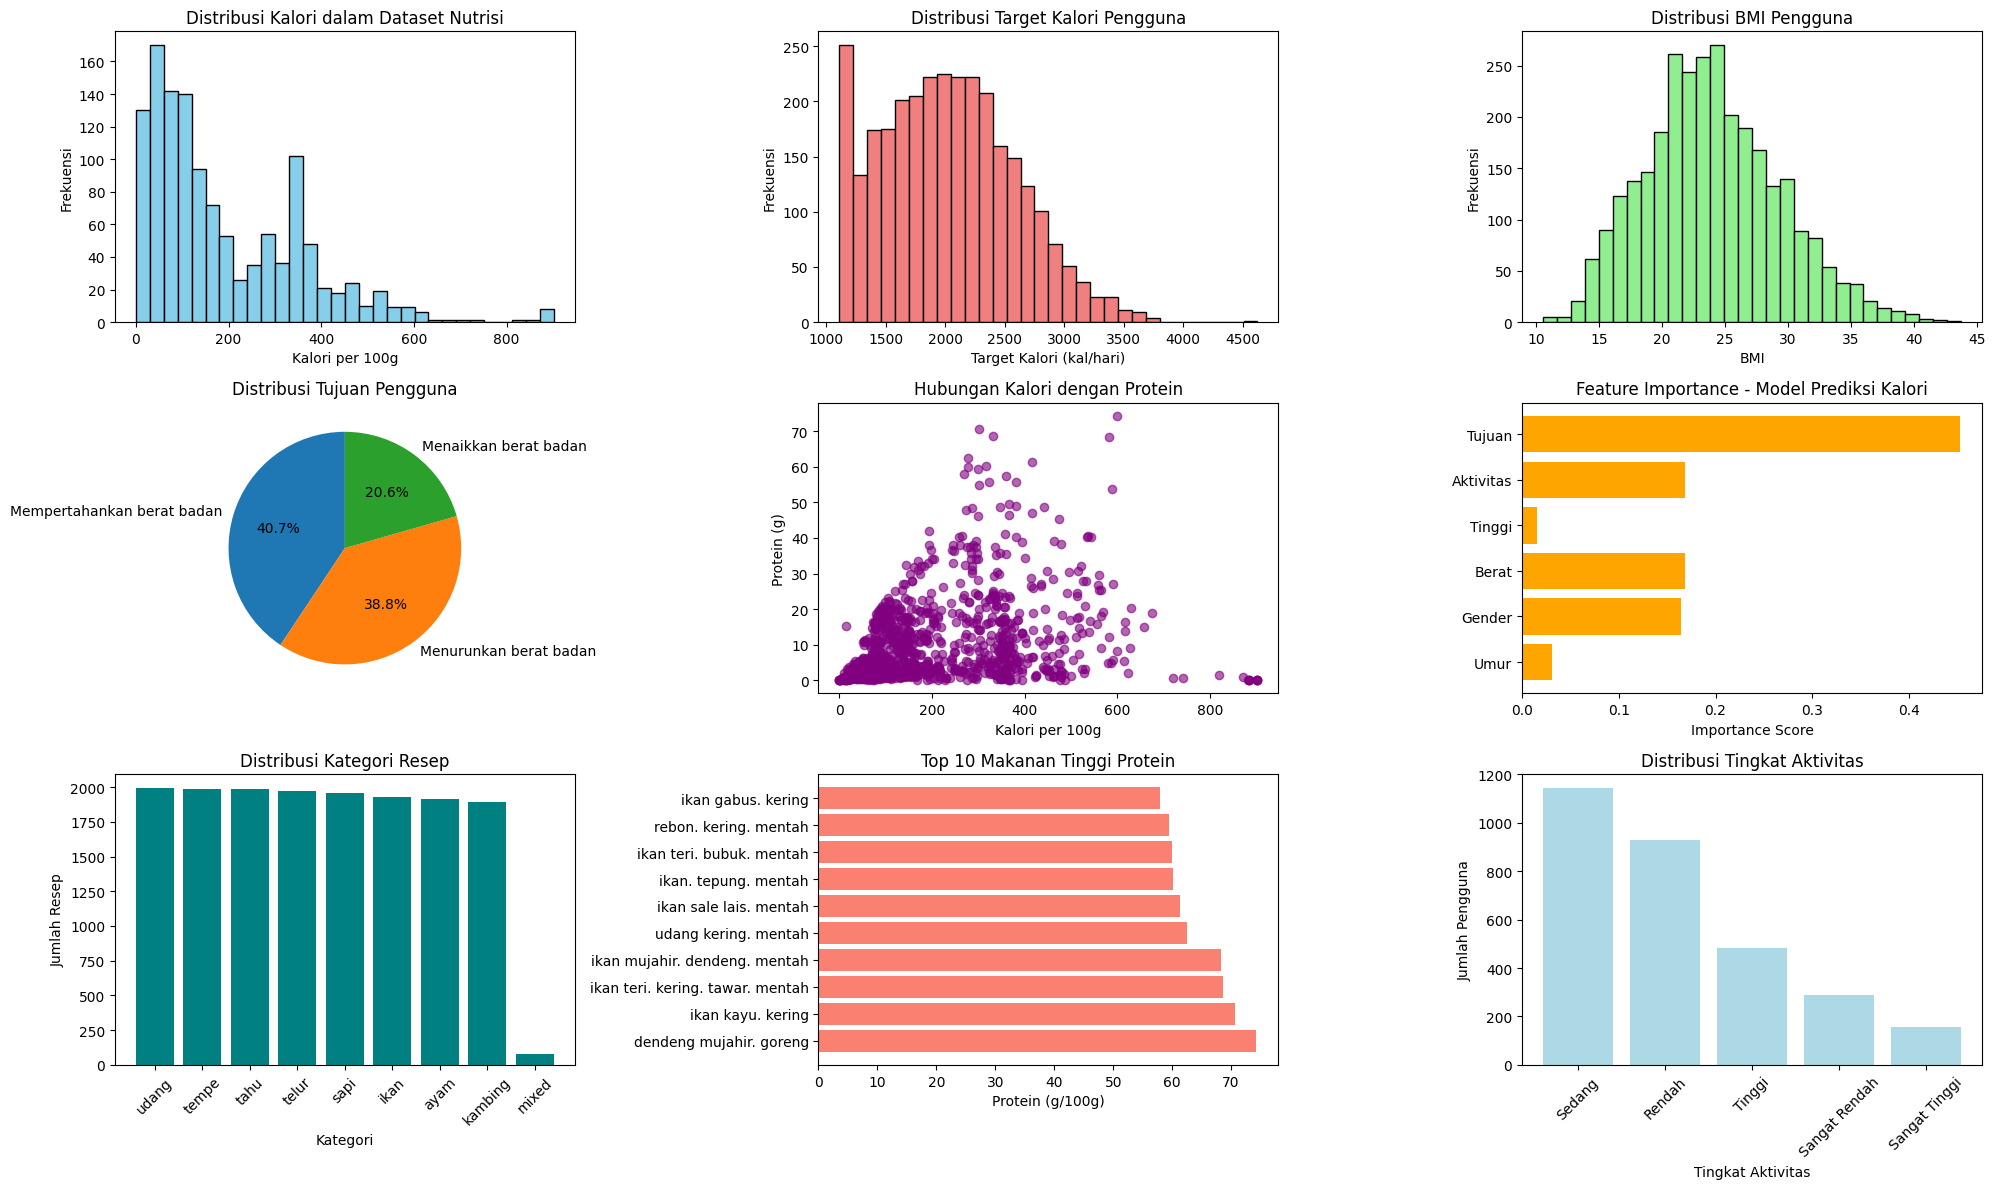

Visualisasi berhasil dibuat dan disimpan!


In [9]:
# Visualisasi
plt.figure(figsize=(20, 12))

# 1. Distribusi kalori dalam dataset nutrisi
plt.subplot(3, 3, 1)
plt.hist(df_nutrition['calories'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Kalori dalam Dataset Nutrisi')
plt.xlabel('Kalori per 100g')
plt.ylabel('Frekuensi')

# 2. Distribusi target kalori pengguna
plt.subplot(3, 3, 2)
plt.hist(df_users['target_calories'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribusi Target Kalori Pengguna')
plt.xlabel('Target Kalori (kal/hari)')
plt.ylabel('Frekuensi')

# 3. Distribusi BMI pengguna
plt.subplot(3, 3, 3)
df_users['bmi'] = df_users['weight'] / (df_users['height']/100)**2
plt.hist(df_users['bmi'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribusi BMI Pengguna')
plt.xlabel('BMI')
plt.ylabel('Frekuensi')

# 4. Distribusi tujuan pengguna
plt.subplot(3, 3, 4)
goal_counts = df_users['goal'].value_counts()
plt.pie(goal_counts.values, labels=goal_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Tujuan Pengguna')

# 5. Hubungan protein vs kalori
plt.subplot(3, 3, 5)
plt.scatter(df_nutrition['calories'], df_nutrition['protein'], alpha=0.6, color='purple')
plt.title('Hubungan Kalori dengan Protein')
plt.xlabel('Kalori per 100g')
plt.ylabel('Protein (g)')

# 6. Feature importance
plt.subplot(3, 3, 6)
feature_importance = calorie_model.feature_importances_
feature_names_display = ['Umur', 'Gender', 'Berat', 'Tinggi', 'Aktivitas', 'Tujuan']
plt.barh(feature_names_display, feature_importance, color='orange')
plt.title('Feature Importance - Model Prediksi Kalori')
plt.xlabel('Importance Score')

# 7. Distribusi kategori resep
plt.subplot(3, 3, 7)
if 'category' in all_recipes_df.columns:
    category_counts = all_recipes_df['category'].value_counts()
    plt.bar(category_counts.index, category_counts.values, color='teal')
    plt.title('Distribusi Kategori Resep')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah Resep')
    plt.xticks(rotation=45)

# 8. Top 10 makanan berdasarkan protein
plt.subplot(3, 3, 8)
top_protein = df_nutrition.nlargest(10, 'protein')[['ingredient', 'protein']]
plt.barh(top_protein['ingredient'], top_protein['protein'], color='salmon')
plt.title('Top 10 Makanan Tinggi Protein')
plt.xlabel('Protein (g/100g)')

# 9. Distribusi aktivitas pengguna
plt.subplot(3, 3, 9)
activity_counts = df_users['activity_level'].value_counts()
plt.bar(activity_counts.index, activity_counts.values, color='lightblue')
plt.title('Distribusi Tingkat Aktivitas')
plt.xlabel('Tingkat Aktivitas')
plt.ylabel('Jumlah Pengguna')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('nutrilance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi berhasil dibuat dan disimpan!")

8. Menyimpan Model dalam Berbagai Format

In [10]:
import os
import json
from datetime import datetime

# Buat direktori untuk menyimpan model
os.makedirs('models', exist_ok=True)

# 1. Simpan menggunakan Pickle
print("Menyimpan model menggunakan Pickle...")
with open('models/nutrilance_models.pkl', 'wb') as f:
    pickle.dump({
        'calorie_model': calorie_model,
        'category_model': category_model,
        'scaler': scaler,
        'encoders': encoders,
        'feature_names': features,
        'model_info': {
            'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'rmse': rmse,
            'r2_score': r2_score,
            'accuracy': accuracy
        }
    }, f)

# 2. Simpan menggunakan Joblib (lebih efisien untuk model scikit-learn)
print("Menyimpan model menggunakan Joblib...")
joblib.dump(calorie_model, 'models/calorie_model.joblib')
joblib.dump(category_model, 'models/category_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')
joblib.dump(encoders, 'models/encoders.joblib')

# 3. Simpan metadata model sebagai JSON
print("Menyimpan metadata model...")
model_metadata = {
    'model_name': 'NUTRILANCE Recommendation System',
    'version': '1.0',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'models': {
        'calorie_prediction': {
            'type': 'RandomForestRegressor',
            'n_estimators': 200,
            'max_depth': 10,
            'performance': {
                'rmse': float(rmse),
                'r2_score': float(r2_score)
            }
        },
        'category_classification': {
            'type': 'RandomForestClassifier',
            'n_estimators': 200,
            'max_depth': 10,
            'performance': {
                'accuracy': float(accuracy)
            }
        }
    },
    'features': features,
    'encoders': {
        'gender': list(le_gender.classes_),
        'activity_level': list(le_activity.classes_),
        'goal': list(le_goal.classes_),
        'nutrient_category': list(le_nutrient_cat.classes_)
    }
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

# 4. Simpan dataset yang sudah diproses
print("Menyimpan dataset...")
df_nutrition.to_csv('models/processed_nutrition_data.csv', index=False)
df_users.to_csv('models/user_profiles.csv', index=False)
all_recipes_df.to_csv('models/processed_recipes.csv', index=False)

# 5. Simpan sistem rekomendasi lengkap
print("Menyimpan sistem rekomendasi lengkap...")
with open('models/recommendation_system.pkl', 'wb') as f:
    pickle.dump(recommendation_system, f)

print("\n✅ Semua model dan data berhasil disimpan!")
print("\nFile yang tersimpan:")
print("- models/nutrilance_models.pkl (Complete model package)")
print("- models/calorie_model.joblib")
print("- models/category_model.joblib")
print("- models/scaler.joblib")
print("- models/encoders.joblib")
print("- models/model_metadata.json")
print("- models/processed_nutrition_data.csv")
print("- models/user_profiles.csv")
print("- models/processed_recipes.csv")
print("- models/recommendation_system.pkl")

Menyimpan model menggunakan Pickle...
Menyimpan model menggunakan Joblib...
Menyimpan metadata model...
Menyimpan dataset...
Menyimpan sistem rekomendasi lengkap...

✅ Semua model dan data berhasil disimpan!

File yang tersimpan:
- models/nutrilance_models.pkl (Complete model package)
- models/calorie_model.joblib
- models/category_model.joblib
- models/scaler.joblib
- models/encoders.joblib
- models/model_metadata.json
- models/processed_nutrition_data.csv
- models/user_profiles.csv
- models/processed_recipes.csv
- models/recommendation_system.pkl


9. Fungsi untuk Load Model

In [11]:
def load_nutrilance_models():
    """Load semua model yang sudah disimpan"""
    print("Loading NUTRILANCE models...")
    
    # Load menggunakan pickle
    with open('models/nutrilance_models.pkl', 'rb') as f:
        models_data = pickle.load(f)
    
    # Load metadata
    with open('models/model_metadata.json', 'r') as f:
        metadata = json.load(f)
    
    print(f"Model version: {metadata['version']}")
    print(f"Created date: {metadata['created_date']}")
    print(f"Calorie model RMSE: {metadata['models']['calorie_prediction']['performance']['rmse']:.2f}")
    print(f"Category model accuracy: {metadata['models']['category_classification']['performance']['accuracy']:.3f}")
    
    return models_data, metadata

# Test loading
loaded_models, loaded_metadata = load_nutrilance_models()
print("\n✅ Model berhasil di-load!")

Loading NUTRILANCE models...
Model version: 1.0
Created date: 2025-06-12 13:26:38
Calorie model RMSE: 81.90
Category model accuracy: 0.893

✅ Model berhasil di-load!


10. API Interface untuk Integrasi Web

In [12]:
class NutrilanceAPI:
    """API interface untuk integrasi dengan web application"""
    
    def __init__(self, model_path='models/nutrilance_models.pkl'):
        # Load models
        with open(model_path, 'rb') as f:
            self.models = pickle.load(f)
        
        # Load nutrition data
        self.nutrition_df = pd.read_csv('models/processed_nutrition_data.csv')
        self.recipes_df = pd.read_csv('models/processed_recipes.csv')
        
        # Initialize recommendation system
        self.recommendation_system = NutrilanceRecommendationSystem(
            self.nutrition_df,
            self.recipes_df,
            self.models['calorie_model'],
            self.models['category_model'],
            self.models['scaler'],
            self.models['encoders']
        )
    
    def predict_calories(self, user_data):
        """API endpoint untuk prediksi kalori"""
        try:
            target_calories, nutrient_category = self.recommendation_system.predict_calorie_needs(
                age=user_data['age'],
                gender=user_data['gender'],
                weight=user_data['weight'],
                height=user_data['height'],
                activity_level=user_data['activity_level'],
                goal=user_data['goal']
            )
            
            # Calculate BMI
            bmi = user_data['weight'] / (user_data['height']/100)**2
            
            return {
                'status': 'success',
                'data': {
                    'target_calories': round(target_calories, 0),
                    'nutrient_category': nutrient_category,
                    'bmi': round(bmi, 2)
                }
            }
        except Exception as e:
            return {
                'status': 'error',
                'message': str(e)
            }
    
    def get_recommendations(self, target_calories, meal_type='all'):
        """API endpoint untuk rekomendasi makanan"""
        try:
            recommendations = self.recommendation_system.recommend_foods(
                target_calories, meal_type, n_recommendations=10
            )
            
            # Convert to dict for JSON serialization
            recommendations_list = []
            for idx, row in recommendations.iterrows():
                recommendations_list.append({
                    'ingredient': row['ingredient'],
                    'calories': round(row['calories'], 0),
                    'protein': round(row['protein'], 1),
                    'fat': round(row['fat'], 1),
                    'carbohydrates': round(row['carbohydrates'], 1),
                    'fiber': round(row['fiber'], 1),
                    'calcium': round(row['calcium'], 0),
                    'score': round(row['nutrition_score'], 3)
                })
            
            return {
                'status': 'success',
                'data': recommendations_list
            }
        except Exception as e:
            return {
                'status': 'error',
                'message': str(e)
            }
    
    def get_meal_plan(self, target_calories, days=1):
        """API endpoint untuk meal plan"""
        try:
            meal_plans = self.recommendation_system.create_daily_meal_plan(
                target_calories, days
            )
            
            # Convert to serializable format
            meal_plans_dict = []
            for plan in meal_plans:
                day_plan = {
                    'day': plan['day'],
                    'meals': {}
                }
                
                for meal_type, meal_data in plan['meals'].items():
                    day_plan['meals'][meal_type] = {
                        'foods': meal_data['foods'].to_dict('records'),
                        'recipes': meal_data['recipes'].to_dict('records')
                    }
                
                meal_plans_dict.append(day_plan)
            
            return {
                'status': 'success',
                'data': meal_plans_dict
            }
        except Exception as e:
            return {
                'status': 'error',
                'message': str(e)
            }

# Initialize API
nutrilance_api = NutrilanceAPI()

# Test API
test_request = {
    'age': 30,
    'gender': 'Perempuan',
    'weight': 65,
    'height': 165,
    'activity_level': 'Sedang',
    'goal': 'Menurunkan berat badan'
}

print("\n=== Testing API ===")
result = nutrilance_api.predict_calories(test_request)
print(f"Prediction result: {result}")

if result['status'] == 'success':
    recommendations = nutrilance_api.get_recommendations(
        result['data']['target_calories'], 
        'sarapan'
    )
    print(f"\nBreakfast recommendations: {len(recommendations['data'])} items")


=== Testing API ===
Prediction result: {'status': 'success', 'data': {'target_calories': np.float64(1617.0), 'nutrient_category': 'Sedang', 'bmi': 23.88}}

Breakfast recommendations: 10 items
